In [1]:
import holoviews as hv

hv.extension("bokeh", logo=False)
hv.output(widget_location="bottom")

# Interactive plots

This notebook show how to use `Holoviews` based plotting methods to create interactive plots of the magnetisation or derived quantities. The interface is the same as in `discretisedfield.Field.hv`. For details on the different plotting methods refer to the documentation of `Holoviews` based plotting in `discretisedfield`.

In [2]:
import os

import discretisedfield as df
import discretisedfield.tools as dft
import numpy as np

import micromagneticdata as md

We have a set of example simulations stored in the test directory of `micromagneticdata` that we use to demonstrate its functionality.

In [3]:
dirname = os.path.join("..", "micromagneticdata", "tests", "test_sample")

## Visualising computed magnetisation data
First, we creata a `Data` object. We need to pass the name of the `micromagneticmodel.System` that we used to run the simulation and optionally an additional path to the base directory.

In [4]:
data = md.Data(name="system_name", dirname=dirname)

The `Data` object contains all simulation runs of the `System`. These are called drives.

In [5]:
data.info

,drive_number,date,time,driver,t,n,n_threads
0,0,2023-11-07,09:47:23,TimeDriver,2.500000e-11,25.0,NaN
1,1,2023-11-07,09:47:24,TimeDriver,1.500000e-11,15.0,NaN
2,2,2023-11-07,09:47:24,TimeDriver,5.000000e-10,250.0,NaN
3,3,2023-11-07,09:47:25,RelaxDriver,NaN,NaN,NaN
4,4,2023-11-07,09:47:26,MinDriver,NaN,NaN,NaN
5,5,2023-11-07,09:47:26,TimeDriver,5.000000e-12,5.0,NaN
6,6,2023-11-07,09:47:26,MinDriver,NaN,NaN,NaN


### Time evolution of the magnetisation

In [6]:
time_drive = data[1]

We first create a plot for the averaged magnetisation components to better understand the behaviour of the system. We can see a precession of all three components of the averaged magnetisation.

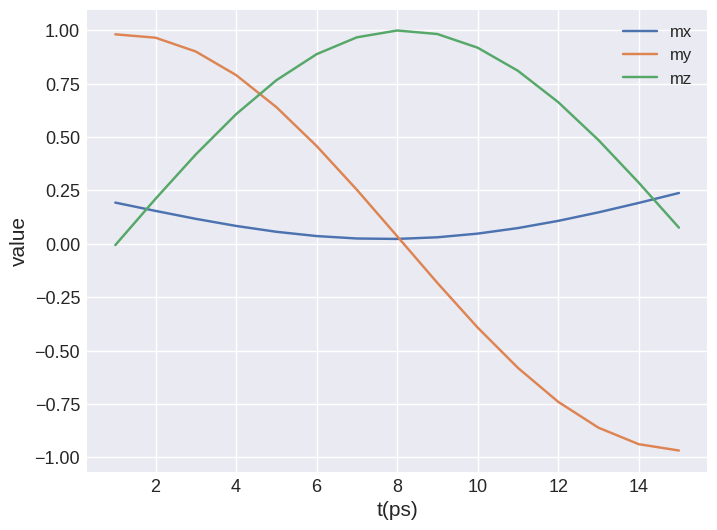

In [7]:
time_drive.table.mpl(y=["mx", "my", "mz"])

We can use the `.hv` convenience method to create a plot similar to the plotting functionality in `discretisedfield`. We get an additional slider for the time variable.

We manually set the colorlimit to (-Ms, Ms) and use a different colormap.

In [8]:
time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-800000, 800000), "cmap": "coolwarm"},
)

:DynamicMap   [z,t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

We can see that the magnetisation direction per time-step is uniform throughout the sample.

In [9]:
time_drive.hv(
    kdims=["y", "z"],
    scalar_kw={"clim": (-800000, 800000), "cmap": "cividis"},
)

:DynamicMap   [x,t]
   :Overlay
      .Image.I       :Image   [y,z]   (field)
      .VectorField.I :VectorField   [y,z]   (angle,mag)

Resampling can be done like in `discretisedfield` using a tuple (to only affect `kdims`)

In [10]:
time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-800000, 800000), "cmap": "coolwarm"},
    vector_kw={"n": (10, 6)},
)

:DynamicMap   [z,t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

### Combining multiple drives

We can combine multiple consecutive time drives to get a single plot showing the whole simulation.

In [11]:
full_time_drive = data[0] << data[1] << data[2]

Again, we first show the scalar plot to better understand the data.

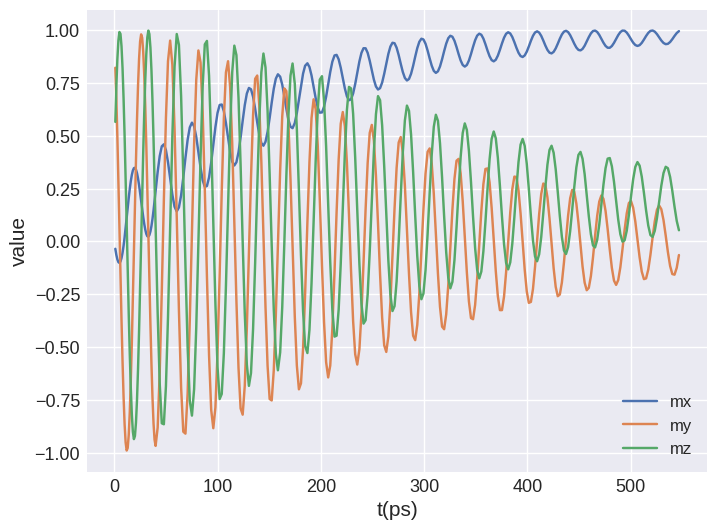

In [12]:
full_time_drive.table.mpl(y=["mx", "my", "mz"])

Now, we can create an interactive plot. Note that the resulution of the time slider changes as we "jump" from the first two drives with fine resolution to the last one with a coarser resolution.

In [13]:
full_time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-800000, 800000), "cmap": "coolwarm"},
    vector_kw={"n": (10, 5)},
)

:DynamicMap   [z,t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

## Computing derived quantities

In this section we look at a different example simulation, the dynamics of a magnetic vortex. We demonstrate how to compute derived quantities based on a series of magnetisation samples from the time drive.

In [14]:
data = md.Data(name="vortex_dynamics", dirname=dirname)

In [15]:
data.info

,drive_number,date,time,driver,n_threads,t,n
0,0,2023-11-07,09:47:26,MinDriver,None,NaN,NaN
1,1,2023-11-07,09:47:27,MinDriver,None,NaN,NaN
2,2,2023-11-07,09:47:27,TimeDriver,None,5.000000e-09,250.0


### Time evolution of the magnetisation

In [16]:
time_drive = data[2]

We first create a plot for the averaged magnetisation components to better understand the behaviour of the system. We can see a damped precession in x and y.

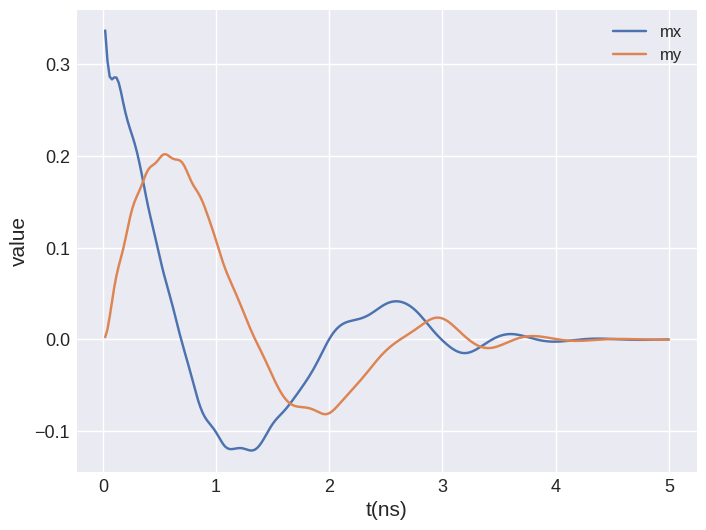

In [17]:
time_drive.table.mpl(y=["mx", "my"])

We can also create an interactive plot for the full magnetisation.

In [18]:
time_drive.hv(kdims=["x", "y"])

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

### Selecting only a part of the drive

We can use slicing notation to select and plot only a part of the data. Here, we select the every 5th of the first 100 samples.

In [19]:
time_drive[:100:5].hv(kdims=["x", "y"])

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

### Normalised magnetisation

To plot the normalised field, we can register a callback function. This function will be applied to each field in the drive before the field is passed to the plotting method. The input argument to this function is a `discretisedfield.Field`. Here, we have a simple function that computes the normalised field (`field.orientation`). As the code for this function is very short, we can use a `lambda` function and define it directly inside the `register_callback` method. The `register_callback` method returns a new drive object that we can plot.

If you are not familiar with `lambda` functions you can also use normal functions as demonstrated in one of the next examples.

In [20]:
time_drive.register_callback(lambda field: field.orientation).hv(kdims=["x", "y"])

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

### Topological charge density - example 1
To give a second example, we compute the topological charge density in the xy plane. This operation is implemented in `discretisedfield.tools`. However, `discretisedfield.tools.topological_charge_density` can only work on a single plane. Therefore, we first select one plane in the z direction and afterwards compute the topological charge density.

Here, we first create a new object and afterwards plot it.

In [21]:
time_drive_tcd_1 = time_drive.register_callback(
    lambda field: dft.topological_charge_density(field.sel("z"))
)

In [22]:
time_drive_tcd_1.hv.scalar(kdims=["x", "y"], cmap="plasma")

:DynamicMap   [t]
   :Image   [x,y]   (field)

### Topological charge density - example 2

If multiple callbacks are registered, these will be applied one after another in the order that they have been registered. Do demonstrate this, we repeat the example of the topological charge density in two steps:

1. We select a xy single plane
2. We compute the topological charge density on that plane

Furthermore, we define our functions outside the `register_callback` method in this example.

In [23]:
def select_plane(field):
    return field.sel("z")


def topological_charge_density(field):
    return dft.topological_charge_density(field)


time_drive_tcd_2 = time_drive.register_callback(select_plane)
time_drive_tcd_2 = time_drive_tcd_2.register_callback(topological_charge_density)
time_drive_tcd_2.hv.scalar(kdims=["x", "y"], cmap="plasma")

:DynamicMap   [t]
   :Image   [x,y]   (field)

It is possible to display all callbacks, as follows. Note however, that this information is difficult to read when using lambda funtions as their names are not very explanatory.

In [24]:
time_drive_tcd_2.callbacks

[<function __main__.select_plane(field)>,
 <function __main__.topological_charge_density(field)>]

## Hysteresis simulation

TODO

In [25]:
data = md.Data(name="hysteresis", dirname=dirname)

In [26]:
data.info

,drive_number,date,time,driver,Hmin,Hmax,n,n_threads
0,0,2023-11-07,09:47:34,HysteresisDriver,"[0, 0, -795774.7154594767]","[0, 0, 795774.7154594767]",21,None


### Time evolution of the magnetisation

In [27]:
drive = data[0]

We first create a plot for the averaged magnetisation components to better understand the behaviour of the system. We can see a damped precession in x and y.

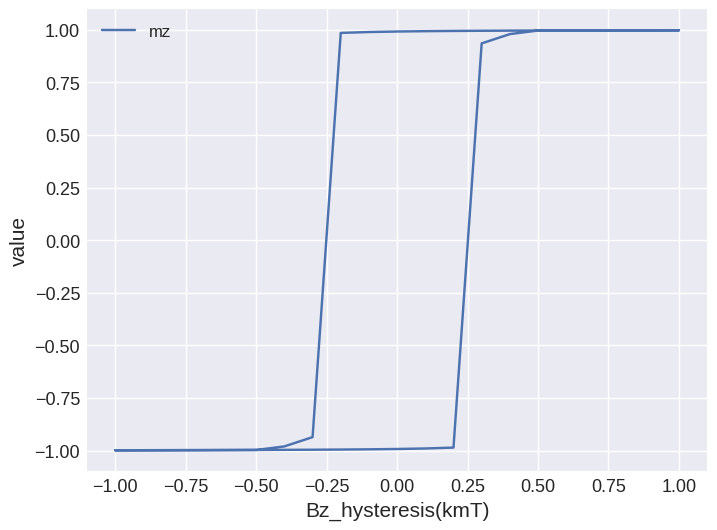

In [28]:
drive.table.mpl(x="Bz_hysteresis", y=["mz"])

We can also create an interactive plot for the full magnetisation.

Note: we have to change the independent variable `drive.x` to the iteration (`stage`) to be able to see the full loop. The default value (`B_hysteresis`) is not unique.

In [29]:
drive.x = "stage"

In [30]:
Ms = np.max(np.abs(drive.m0.norm.array))

drive.register_callback(lambda field: field.z).hv(
    kdims=["x", "z"], scalar_kw={"clim": (-Ms, Ms)}
)

:DynamicMap   [y,stage]
   :Image   [x,z]   (field)